In [337]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import math
import warnings


In [338]:
data = pd.read_csv('Most Streamed Spotify Songs 2024.csv', sep=',', encoding='ISO-8859-1')
print(data.head())

print(data.shape)  # This should show (4800, x)


                        Track                    Album Name          Artist  \
0         MILLION DOLLAR BABY  Million Dollar Baby - Single   Tommy Richman   
1                 Not Like Us                   Not Like Us  Kendrick Lamar   
2  i like the way you kiss me    I like the way you kiss me         Artemas   
3                     Flowers              Flowers - Single     Miley Cyrus   
4                     Houdini                       Houdini          Eminem   

  Release Date          ISRC All Time Rank  Track Score Spotify Streams  \
0    4/26/2024  QM24S2402528             1        725.4     390,470,936   
1     5/4/2024  USUG12400910             2        545.9     323,703,884   
2    3/19/2024  QZJ842400387             3        538.4     601,309,283   
3    1/12/2023  USSM12209777             4        444.9   2,031,280,633   
4    5/31/2024  USUG12403398             5        423.3     107,034,922   

  Spotify Playlist Count Spotify Playlist Reach  ...  SiriusXM Spins  \
0 

In [339]:
# Convert string columns to integers where possible
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].str.replace(',', '', regex=True)
        try:
            data[col] = pd.to_numeric(data[col])
        except ValueError:
            continue

# Convert 'Release Date' to datetime format
data['Release Date'] = pd.to_datetime(data['Release Date'], errors='coerce')


In [340]:
data = pd.read_csv('Most Streamed Spotify Songs 2024.csv', sep=',', encoding='ISO-8859-1')

# Drop empty column
data.drop(columns=['TIDAL Popularity'], inplace=True)
data.drop_duplicates(inplace=True)
missing_values = data.isnull().sum()
print(missing_values)


Track                            0
Album Name                       0
Artist                           5
Release Date                     0
ISRC                             0
All Time Rank                    0
Track Score                      0
Spotify Streams                113
Spotify Playlist Count          70
Spotify Playlist Reach          72
Spotify Popularity             804
YouTube Views                  308
YouTube Likes                  315
TikTok Posts                  1173
TikTok Likes                   980
TikTok Views                   981
YouTube Playlist Reach        1009
Apple Music Playlist Count     561
AirPlay Spins                  498
SiriusXM Spins                2123
Deezer Playlist Count          921
Deezer Playlist Reach          928
Amazon Playlist Count         1055
Pandora Streams               1106
Pandora Track Stations        1268
Soundcloud Streams            3332
Shazam Counts                  577
Explicit Track                   0
dtype: int64


In [341]:
columns_to_clean = [
    'Spotify Playlist Count', 'Spotify Playlist Reach', 'YouTube Views', 'YouTube Likes', 
    'TikTok Posts', 'TikTok Likes', 'TikTok Views', 'YouTube Playlist Reach', 
    'Apple Music Playlist Count', 'AirPlay Spins', 'SiriusXM Spins', 'Deezer Playlist Count', 
    'Deezer Playlist Reach', 'Amazon Playlist Count', 'Pandora Streams', 
    'Pandora Track Stations', 'Soundcloud Streams', 'Shazam Counts'
]


for col in columns_to_clean:
    data[col] = data[col].replace({',': ''}, regex=True)  
    data[col] = pd.to_numeric(data[col], errors='coerce')  

# Fill missing values with the median
for col in columns_to_clean:
    data[col].fillna(data[col].median(), inplace=True)

# Fill missing values for 'Artist' with mode (since it is categorical)
data['Artist'].fillna(data['Artist'].mode()[0], inplace=True)


data['Spotify Popularity'].fillna(data['Spotify Popularity'].median(), inplace=True)


print(data.isnull().sum())



print(data.shape)  # This should show (4800, x)

Track                           0
Album Name                      0
Artist                          0
Release Date                    0
ISRC                            0
All Time Rank                   0
Track Score                     0
Spotify Streams               113
Spotify Playlist Count          0
Spotify Playlist Reach          0
Spotify Popularity              0
YouTube Views                   0
YouTube Likes                   0
TikTok Posts                    0
TikTok Likes                    0
TikTok Views                    0
YouTube Playlist Reach          0
Apple Music Playlist Count      0
AirPlay Spins                   0
SiriusXM Spins                  0
Deezer Playlist Count           0
Deezer Playlist Reach           0
Amazon Playlist Count           0
Pandora Streams                 0
Pandora Track Stations          0
Soundcloud Streams              0
Shazam Counts                   0
Explicit Track                  0
dtype: int64
(4598, 28)


C:\Users\janbe\AppData\Local\Temp\ipykernel_19240\2249319242.py:16: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\janbe\AppData\Local\Temp\ipykernel_19240\2249319242.py:16: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

In [342]:
data['Release Date'] = pd.to_datetime(data['Release Date'], errors='coerce')


# Define a recent release threshold and create a new feature 'Is_Recent'
latest_date = data['Release Date'].max()
one_year_ago = latest_date - pd.DateOffset(years=1)
data['Is_Recent'] = (data['Release Date'] >= one_year_ago).astype(int)

# Recency analysis
recency_analysis = data.groupby('Is_Recent')['Track Score'].mean()

# Print the recency analysis results
print(recency_analysis)


Is_Recent
0    38.915869
1    48.846137
Name: Track Score, dtype: float64


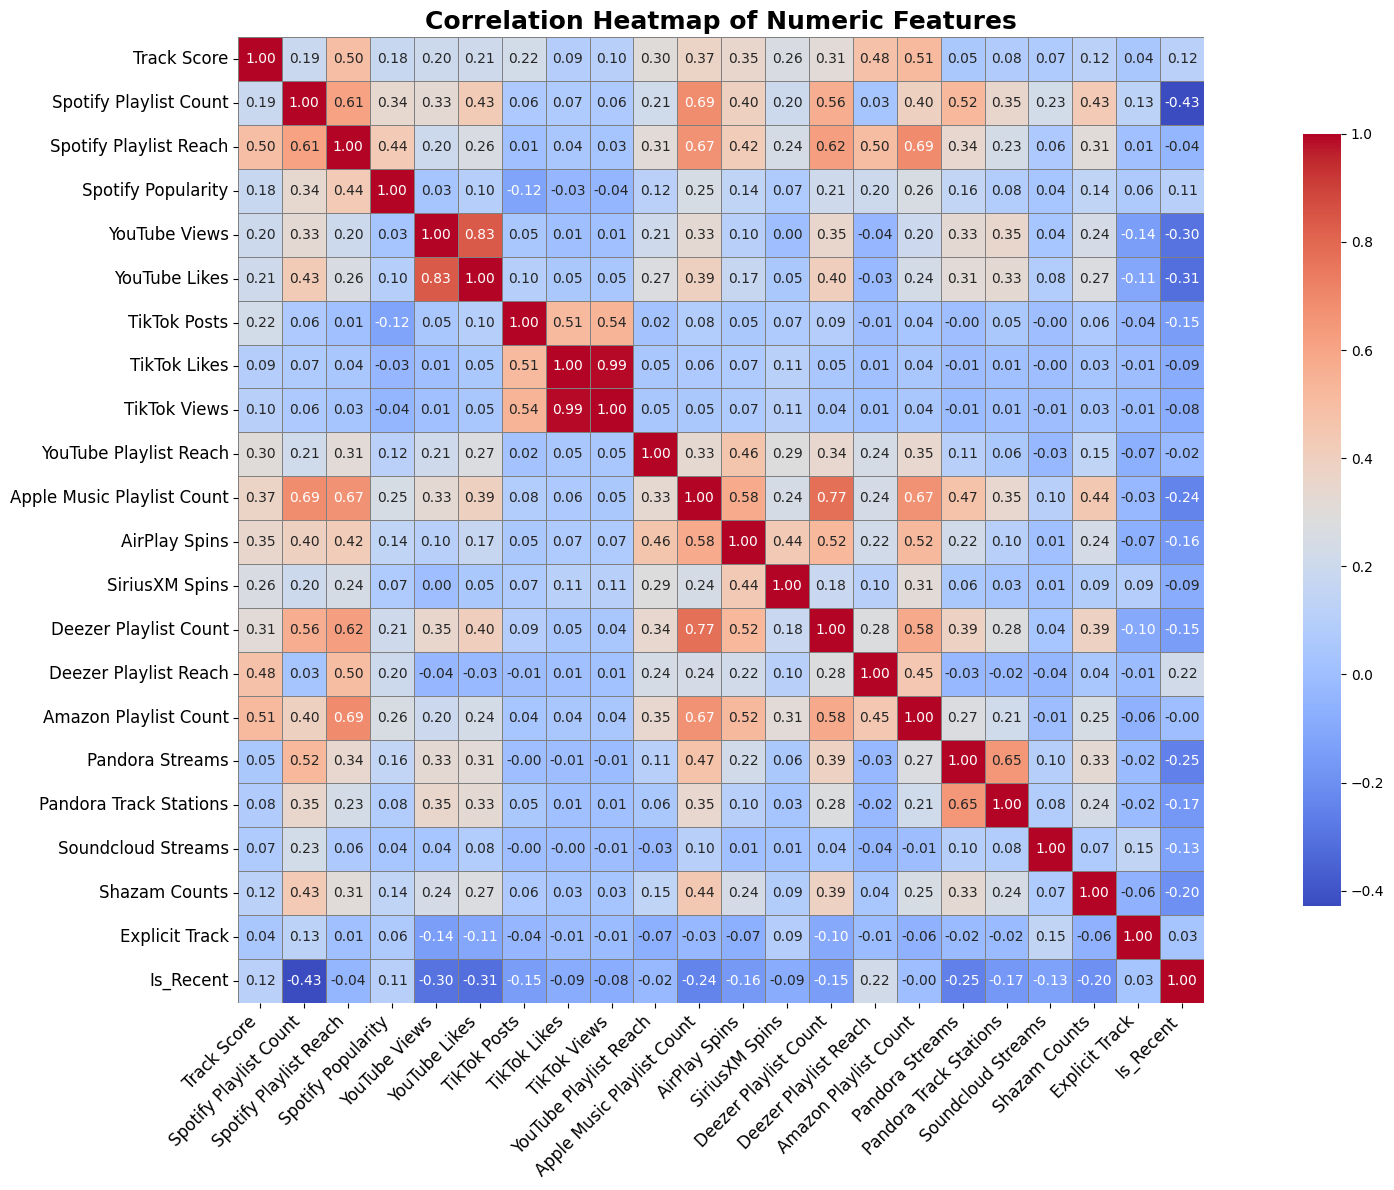

In [343]:
# %% Correlation Heatmap
numeric_data = data.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(20, 12))
corr_matrix = numeric_data.corr()
sns.heatmap(
    corr_matrix, annot=True, cmap="coolwarm", fmt=".2f",
    linewidths=0.5, linecolor='gray', cbar_kws={"shrink": .8}, square=True
)
plt.title('Correlation Heatmap of Numeric Features', fontsize=18, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

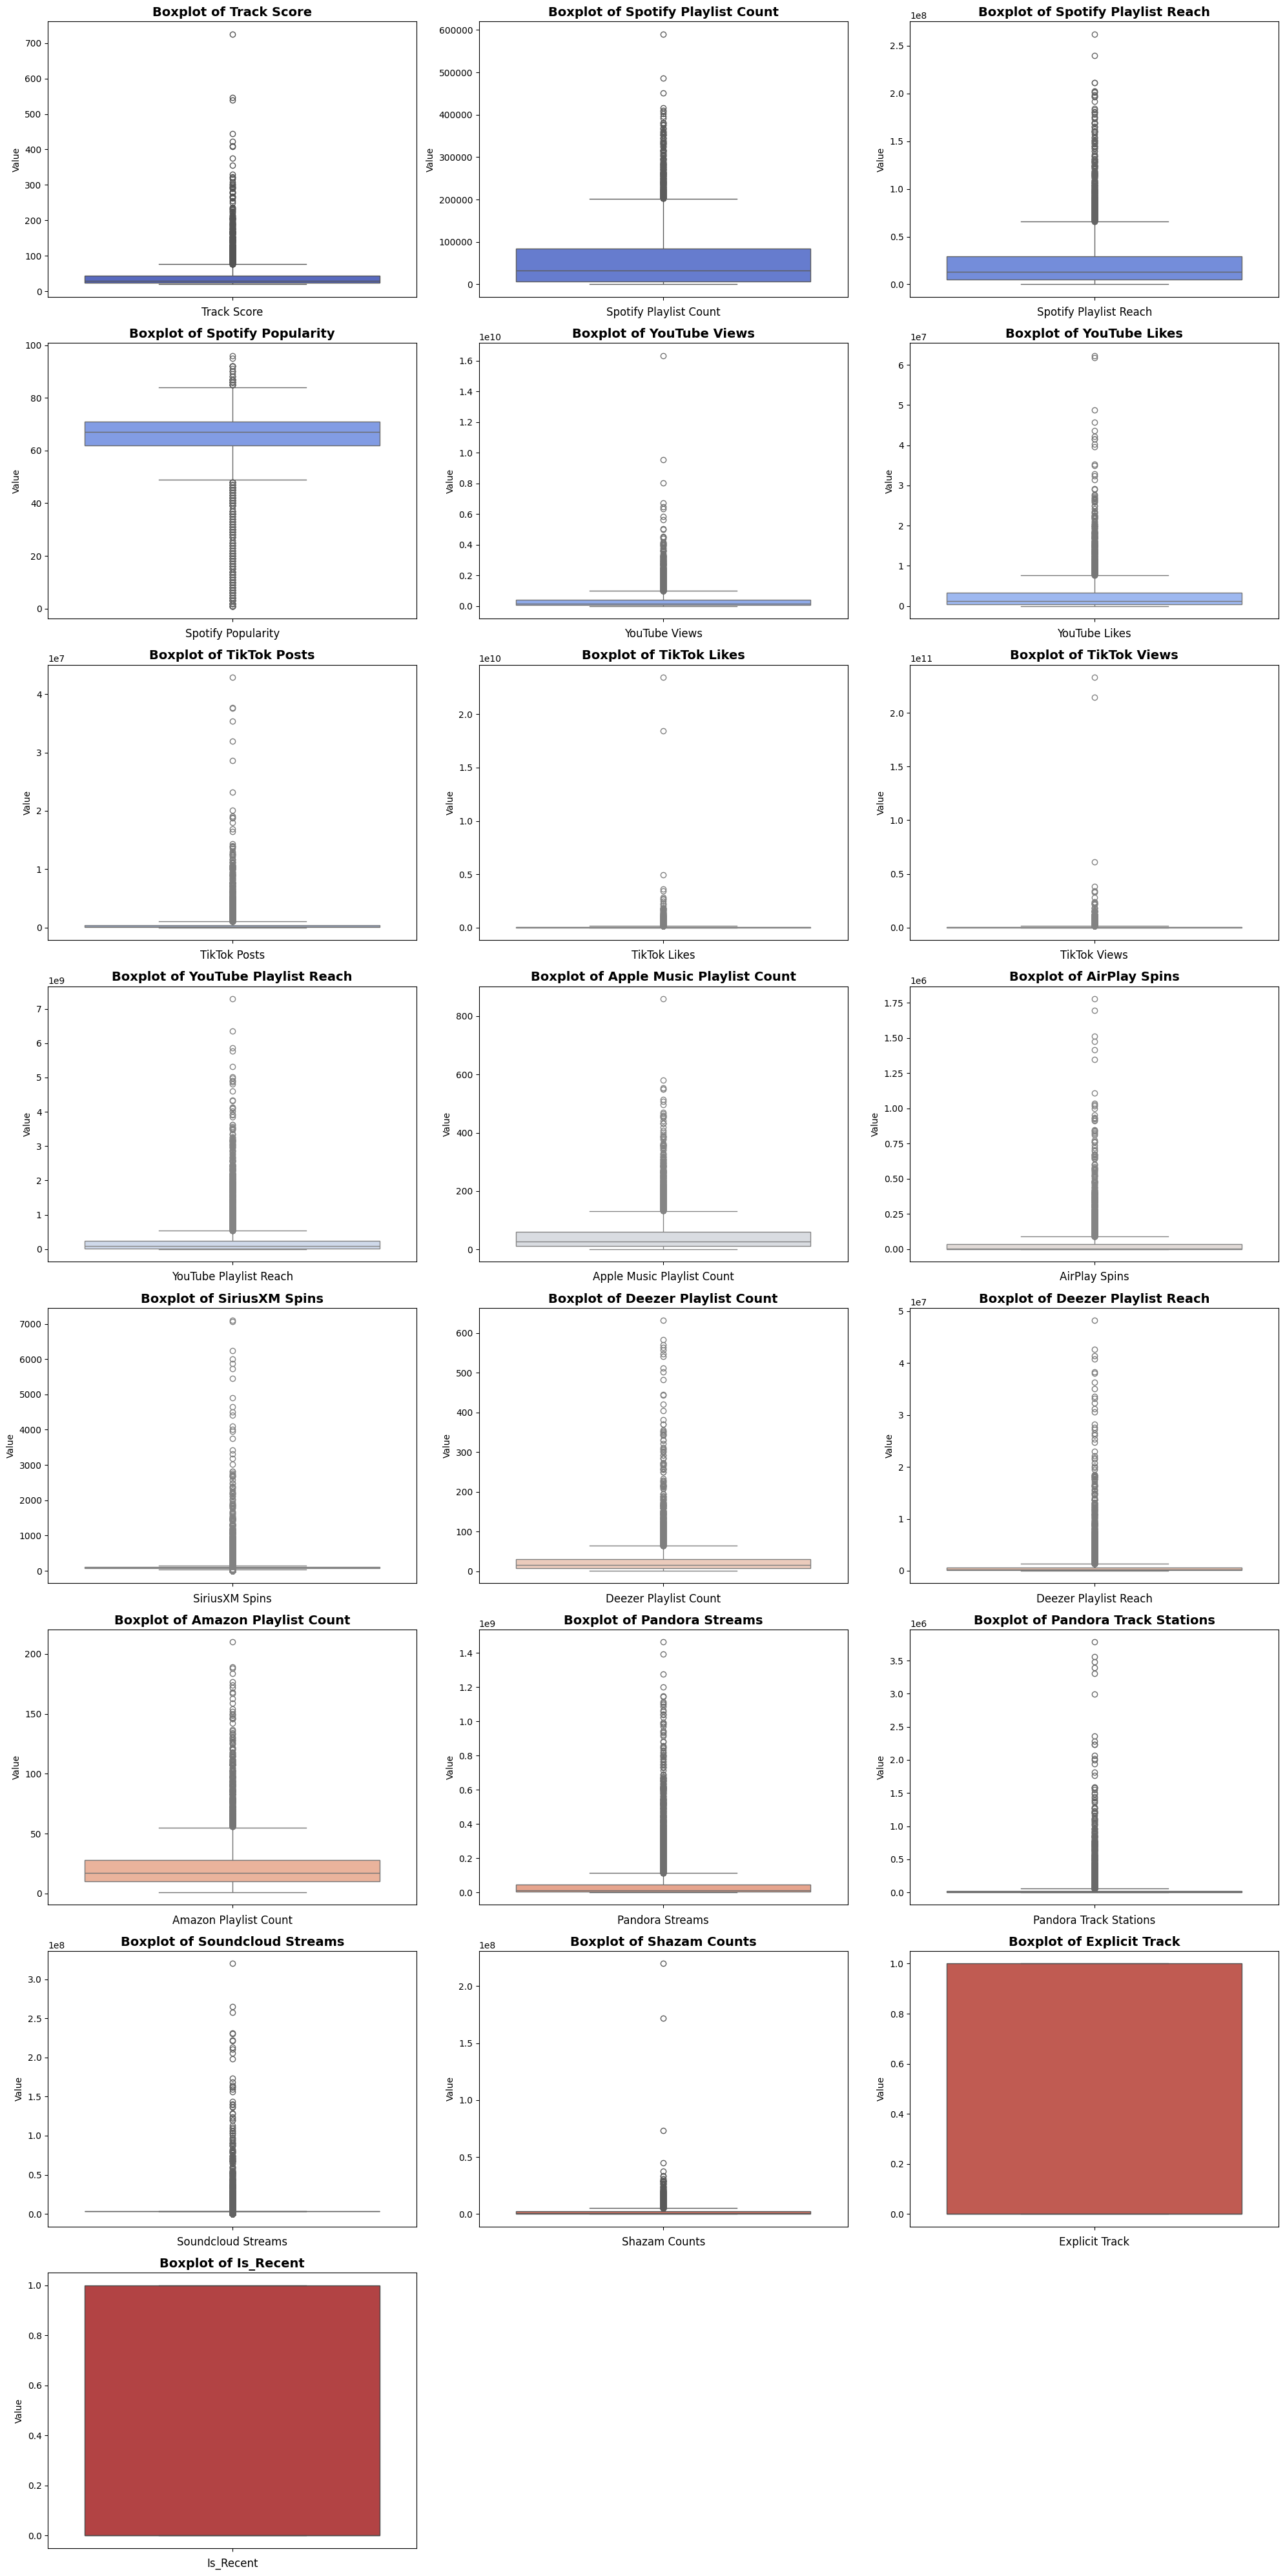

In [344]:

def plot_boxplots(data):
    """
    Function to plot boxplots for each numeric column in the provided DataFrame.
    
    Parameters:
    - data (pd.DataFrame): The input data containing numeric columns for plotting.
    """
    # Ensure the data contains only numeric columns
    numeric_data = data.select_dtypes(include=['float64', 'int64'])

    # Set up the figure grid layout
    num_columns = len(numeric_data.columns)
    num_rows = math.ceil(num_columns / 3)
    fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(20, num_rows * 5))

    # Flatten the axes array for easier handling (even if only one row or column exists)
    axes = axes.flatten()

    # Define a color palette with as many colors as columns
    palette = sns.color_palette("coolwarm", num_columns)

    # Loop through each numeric column and plot the boxplot, applying individual colors
    for i, column in enumerate(numeric_data.columns):
        sns.boxplot(data=numeric_data[column], ax=axes[i], color=palette[i])
        axes[i].set_title(f'Boxplot of {column}', fontsize=14, weight='bold')
        axes[i].set_xlabel(column, fontsize=12)
        axes[i].set_ylabel('Value')

    # Remove any unused axes (if any exist due to uneven subplot grid)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()
    
    
    
plot_boxplots(numeric_data)



 **Outlier Removal**: Apply the IQR method to remove outliers from numeric data columns.
uncomment if necessarry, or use different method

In [345]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler


def scale_data(data, scaler):
    """
    Function to scale the data using a specified scaler.
    
    Parameters:
    - data (pd.DataFrame): The input data to scale.
    - scaler (sklearn.preprocessing): The scaler to apply.
    
    Returns:
    - pd.DataFrame: Scaled data.
    """
    scaled_data = scaler.fit_transform(data)
    
    return pd.DataFrame(scaled_data, columns=data.columns)

scaler_robust = RobustScaler()
scaled_robust = scale_data(numeric_data, scaler_robust)

scaler_minmax = MinMaxScaler()
scaled_minmax = scale_data(numeric_data, scaler_minmax)

scaler_standard = StandardScaler()
scaled_standard = scale_data(numeric_data, scaler_standard)




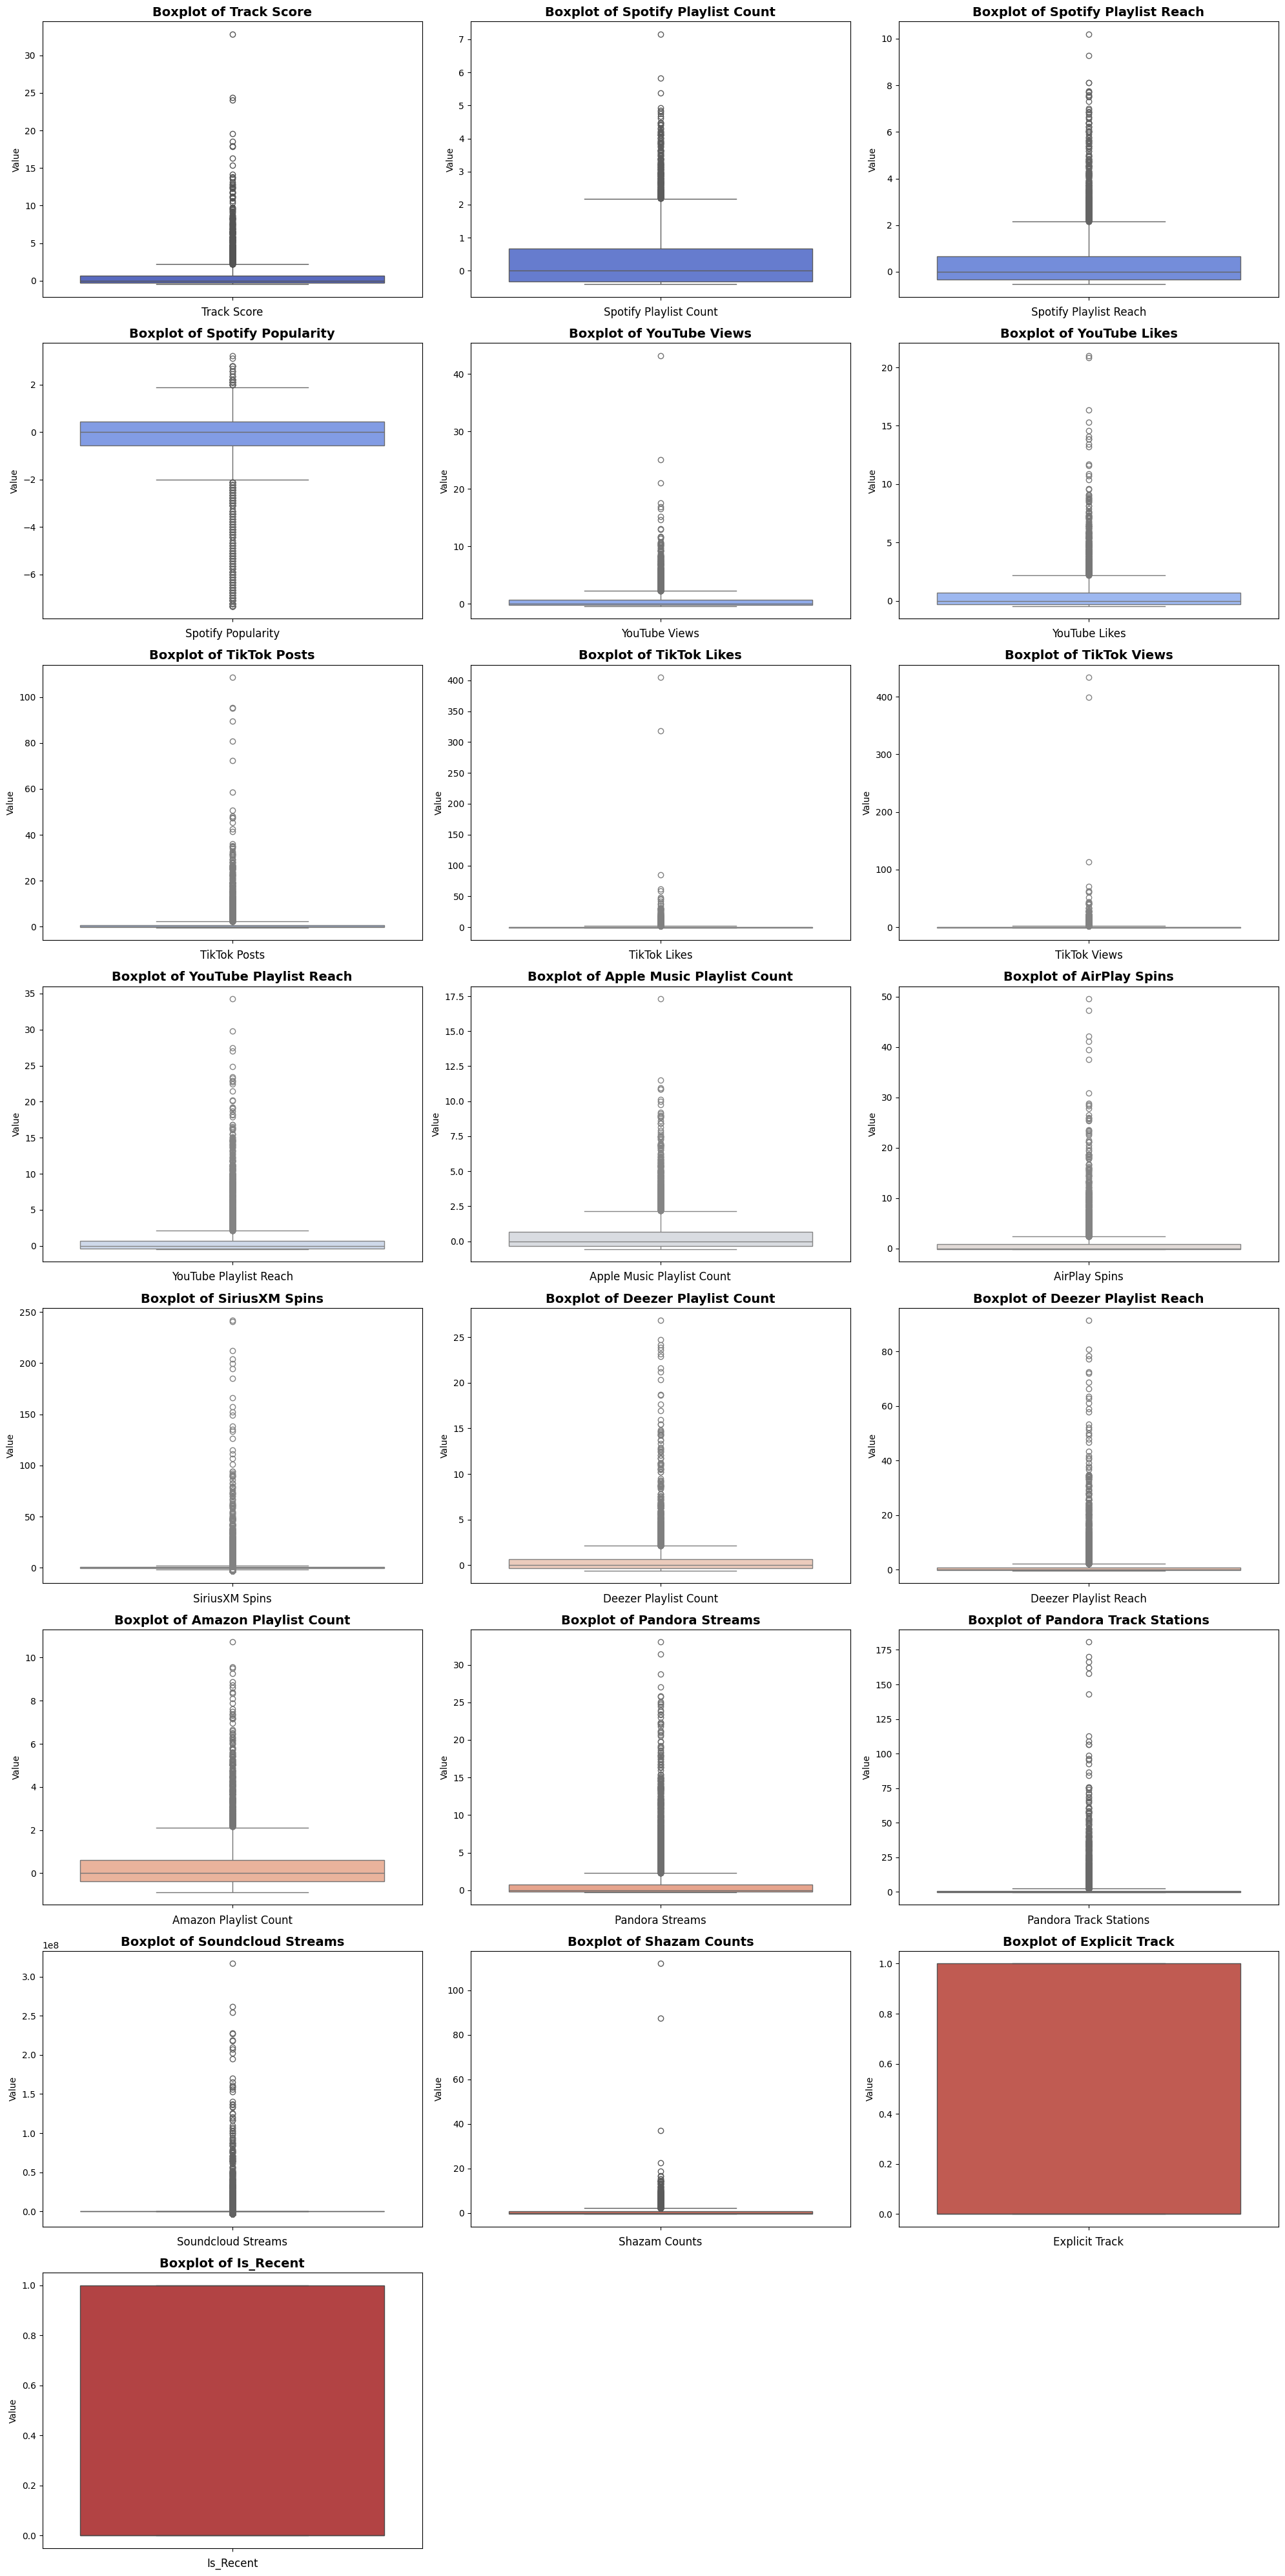

In [346]:
plot_boxplots(scaled_robust)

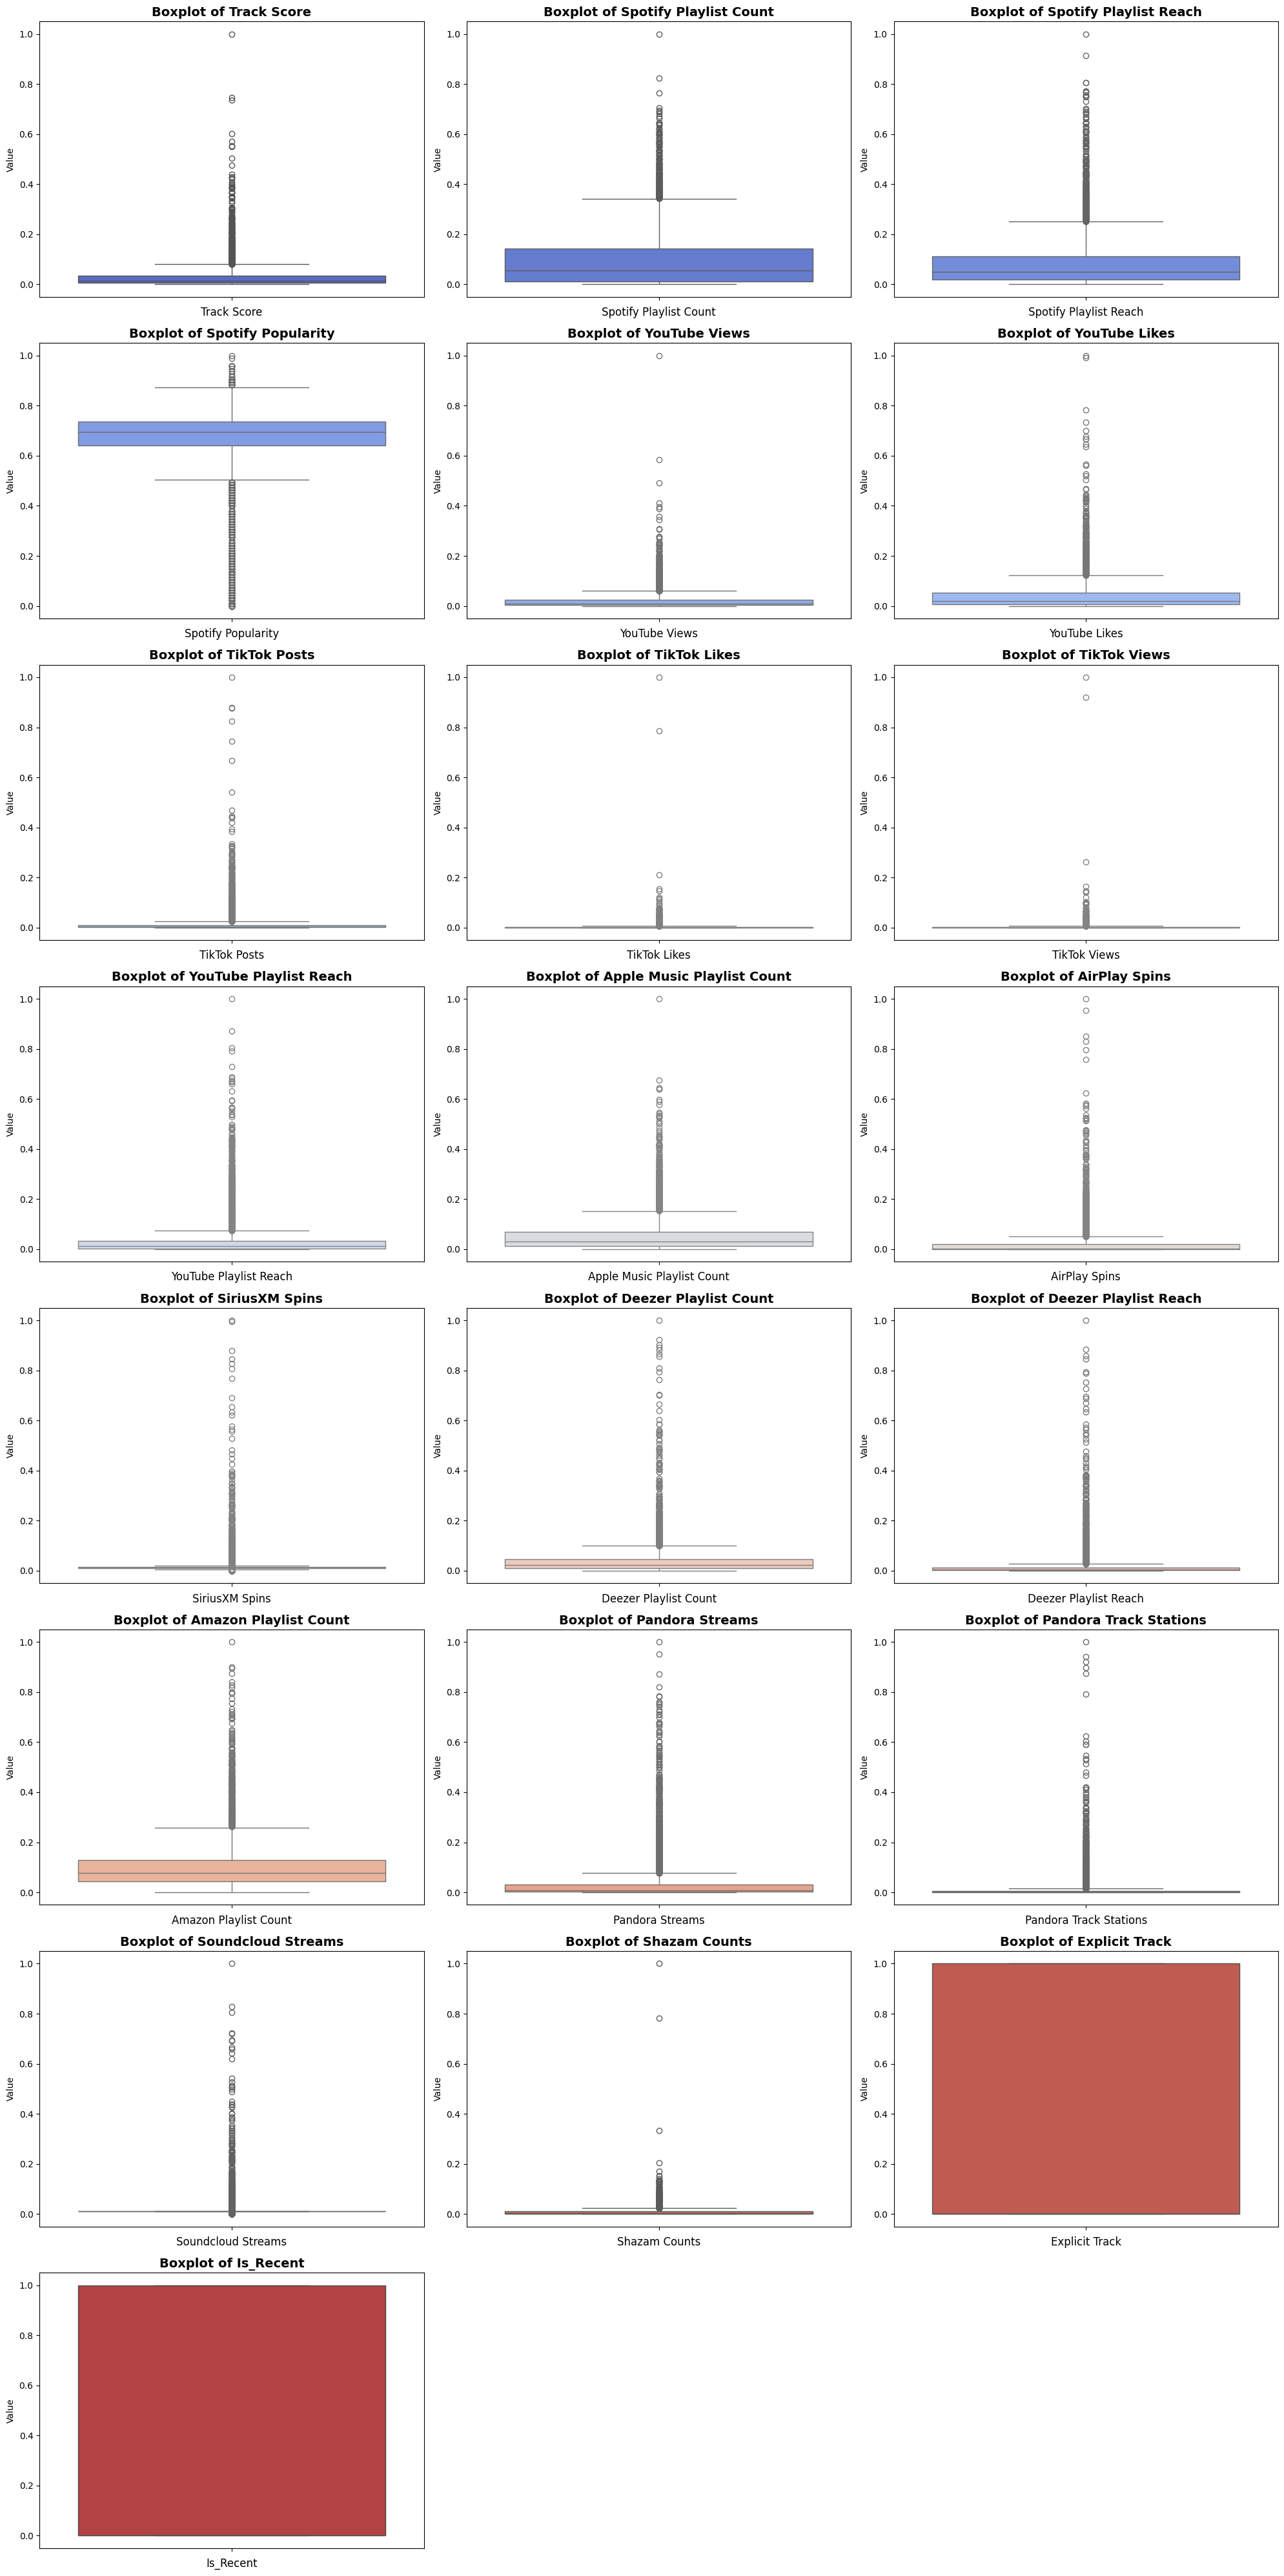

In [347]:
plot_boxplots(scaled_minmax)

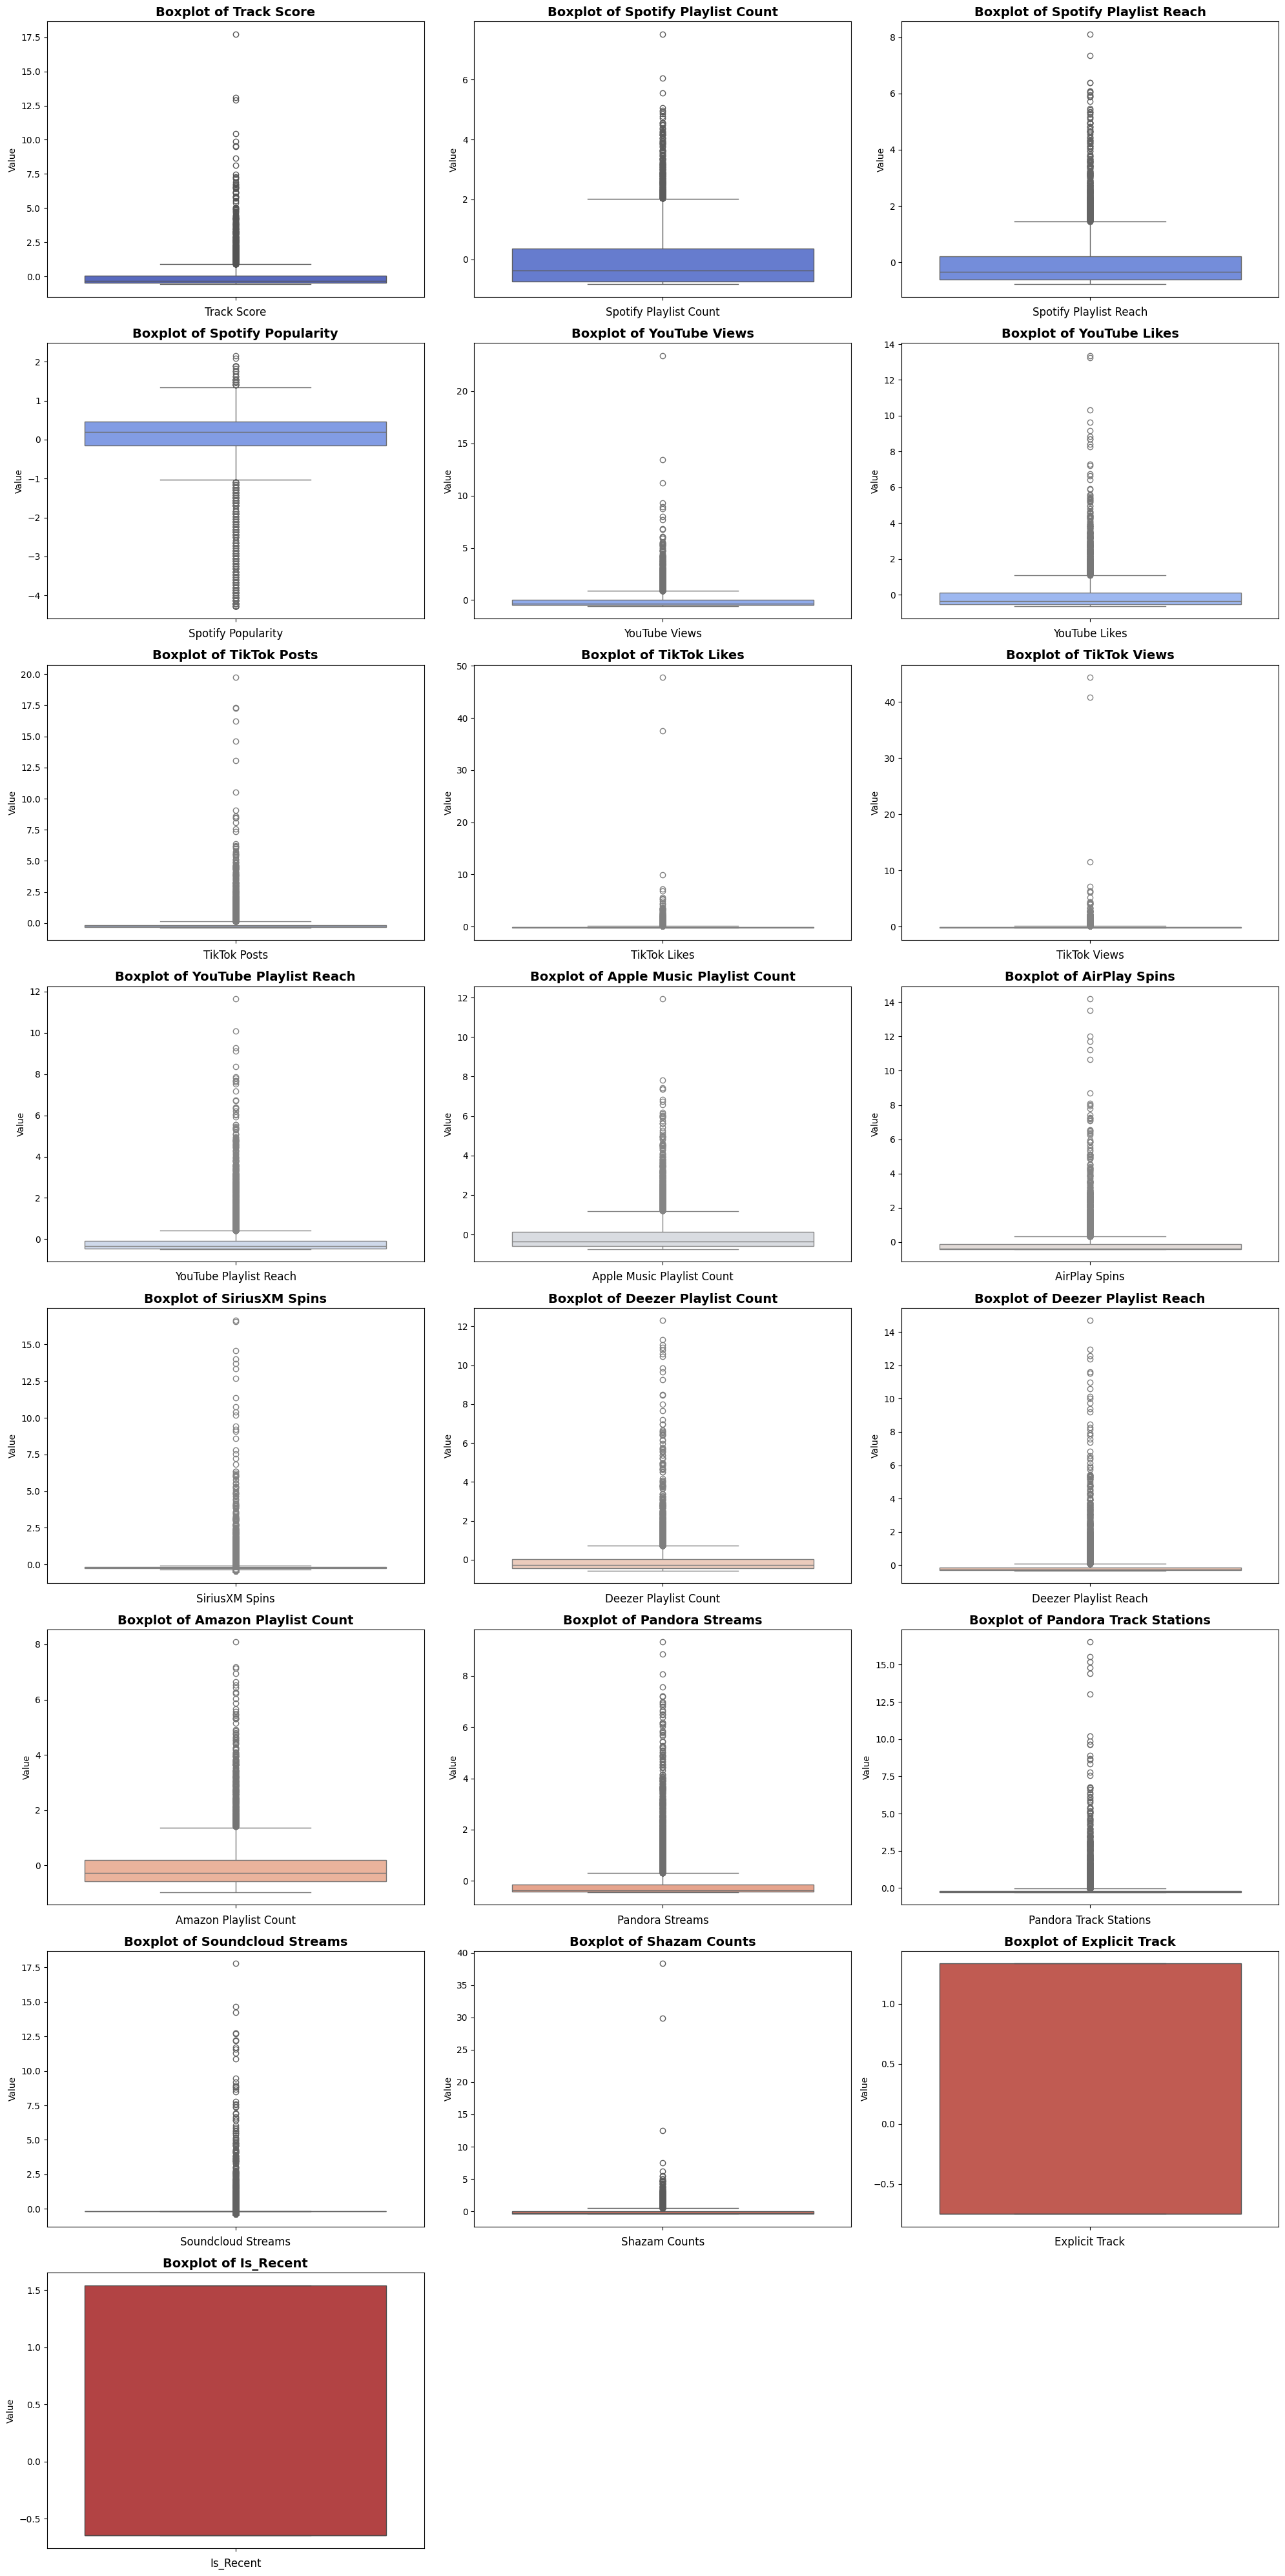

In [348]:
plot_boxplots(scaled_standard)

**Outliers Handling **

Index(['Track Score', 'Spotify Playlist Count', 'Spotify Playlist Reach',
       'Spotify Popularity', 'YouTube Views', 'YouTube Likes', 'TikTok Posts',
       'TikTok Likes', 'TikTok Views', 'YouTube Playlist Reach',
       'Apple Music Playlist Count', 'AirPlay Spins', 'SiriusXM Spins',
       'Deezer Playlist Count', 'Deezer Playlist Reach',
       'Amazon Playlist Count', 'Pandora Streams', 'Pandora Track Stations',
       'Soundcloud Streams', 'Shazam Counts', 'Explicit Track', 'Is_Recent'],
      dtype='object')


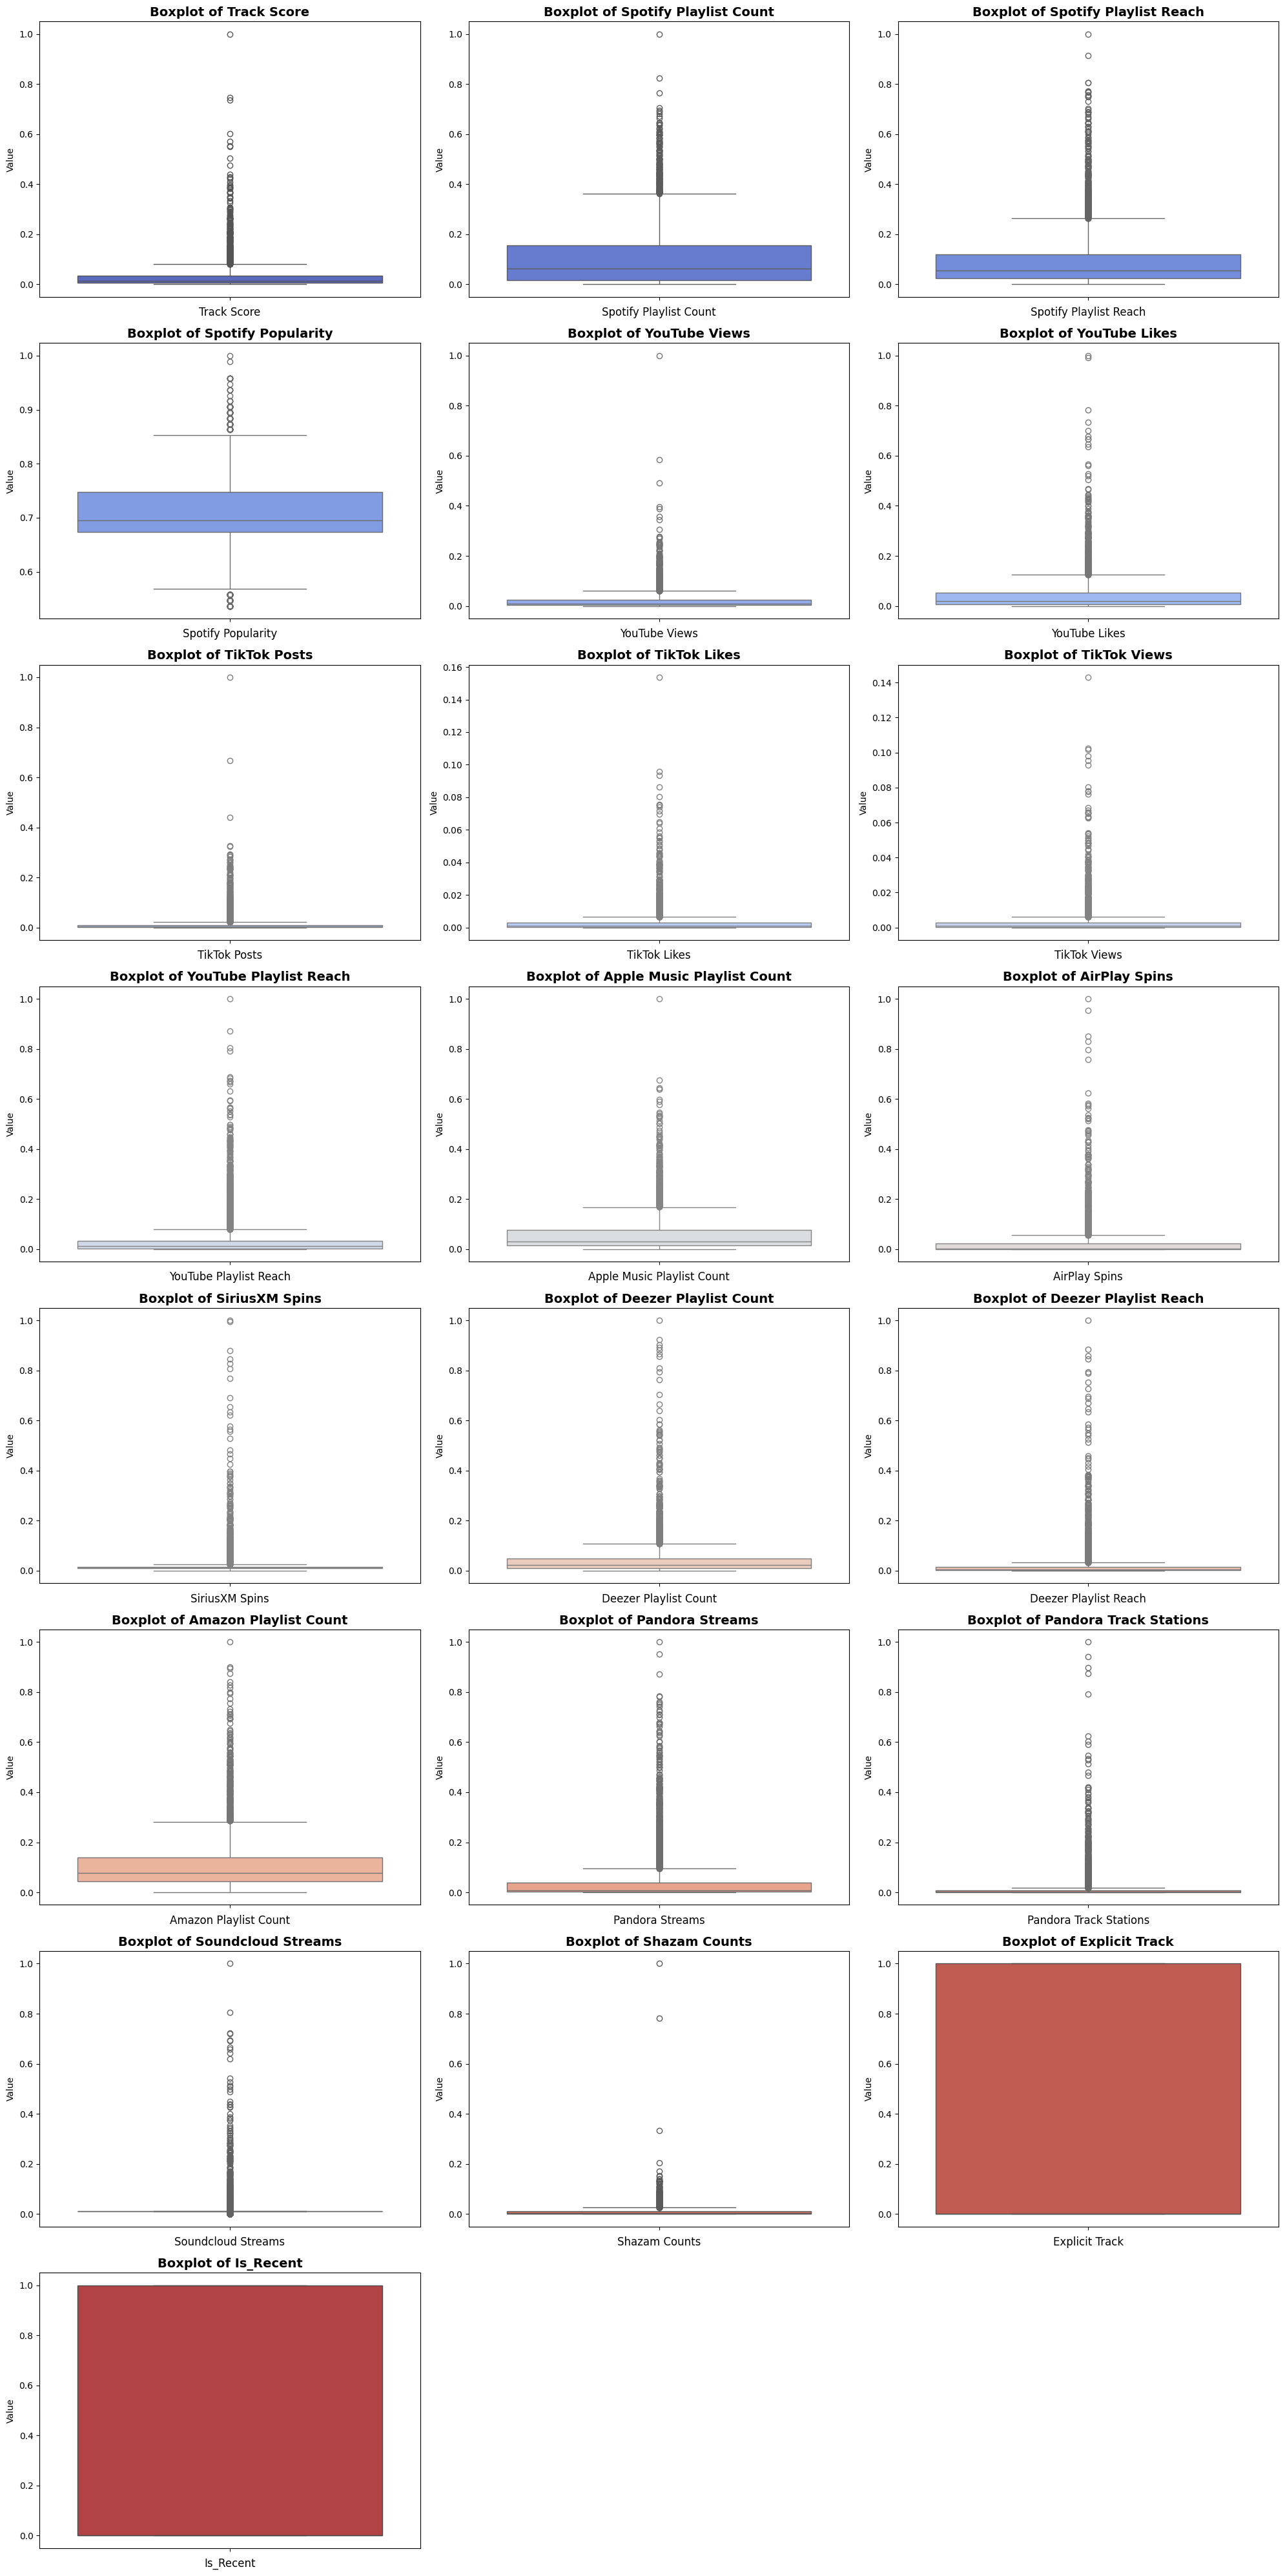

In [349]:
import pandas as pd
from sklearn.preprocessing import RobustScaler

def remove_outliers(data, columns, side='both'):
    """
    Function to remove outliers from data.

    Parameters:
    - data (pd.DataFrame): The DataFrame from which we remove outliers.
    - columns (list): List of columns where we want to remove outliers.
    - side (str): Specifies which outliers to remove:
        - 'both' - removes outliers from both sides (upper and lower boundaries),
        - 'upper' - removes outliers only from the upper boundary,
        - 'lower' - removes outliers only from the lower boundary.

    Returns:
    - pd.DataFrame: The DataFrame after removing the outliers.
    """
    
    data_cleaned = data.copy()  # Create a copy of the data to avoid modifying the original
    
    for column in columns:
        Q1 = data_cleaned[column].quantile(0.1)
        Q3 = data_cleaned[column].quantile(0.1)
        IQR = Q3 - Q1
        
        # Calculate the boundaries for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        if side == 'both' or side == 'lower':
            # Remove outliers from the lower side
            data_cleaned = data_cleaned[data_cleaned[column] >= lower_bound]
        
        if side == 'both' or side == 'upper':
            # Remove outliers from the upper side
            data_cleaned = data_cleaned[data_cleaned[column] <= upper_bound]
    
    return data_cleaned


def cut_values(data, columns, lower_threshold=None, upper_threshold=None):
    """
    Function to truncate values in specified columns that exceed the thresholds.

    Parameters:
    - data (pd.DataFrame): The DataFrame containing the columns to be modified.
    - columns (list): List of columns where values should be truncated.
    - lower_threshold (float, optional): The lower threshold below which values will be clipped.
    - upper_threshold (float, optional): The upper threshold above which values will be clipped.

    Returns:
    - pd.DataFrame: The DataFrame with truncated values.
    """
    
    data_cut = data.copy()  # Create a copy of the data to avoid modifying the original
    
    for column in columns:
        if lower_threshold is not None:
            # Cut values below the lower threshold
            data_cut[column] = data_cut[column].clip(lower=lower_threshold)
        
        if upper_threshold is not None:
            # Cut values above the upper threshold
            data_cut[column] = data_cut[column].clip(upper=upper_threshold)
    
    return data_cut






columns_with_outliers_on_upper_side = ["Track Score", "Spotify Playlist Count", "Spotify Playlist Reach", "YouTube Views",
                                       "YouTube Likes", "TikTok Posts", "TikTok Likes", "YouTube Playlist Reach", "Apple Music Playlist Count",
                                        "SiriusXM Spins", "Deezer Playlist Count", "Deezer Playlist Reach", "Amazon Playlist Count",
                                       "Pandora Streams", "Pandora Track Stations", "Shazam Counts"]

columns_with_outliers_on_lower_side = ["Spotify Popularity"]





# Remove outliers from columns with outliers on the upper side
for column in columns_with_outliers_on_upper_side: 
    scaled_data = remove_outliers(scaled_minmax, columns=[column], side="upper")

# Remove outliers from columns with outliers on the lower side
for column in columns_with_outliers_on_lower_side: 
    scaled_data = remove_outliers(scaled_minmax, columns=[column], side="lower")


print(scaled_minmax.columns)
'''
scaled_data=cut_values(scaled_minmax, ['Track Score'], upper_threshold=0.8)
scaled_data=cut_values(scaled_minmax, ["Spotify Playlist Count"], upper_threshold=0.8)
scaled_data=cut_values(scaled_minmax, ["Spotify Playlist Reach"], upper_threshold=0.8)
scaled_data=cut_values(scaled_minmax, ["YouTube Likes"], upper_threshold=0.75)
scaled_data=cut_values(scaled_minmax, ["YouTube Views"], upper_threshold=0.6)
scaled_data=cut_values(scaled_minmax, ["TikTok Posts"], upper_threshold=0.3)
scaled_data=cut_values(scaled_minmax, ["TikTok Likes"], upper_threshold=0.2)
scaled_data=cut_values(scaled_minmax, ["TikTok Views"], upper_threshold=0.2)
scaled_data=cut_values(scaled_minmax, ["YouTube Playlist Reach"], upper_threshold=0.75)
scaled_data=cut_values(scaled_minmax, ["Apple Music Playlist Count"], upper_threshold=0.7)
scaled_data=cut_values(scaled_minmax, ["AirPlay Spins"], upper_threshold=0.6)
scaled_data=cut_values(scaled_minmax, ["SiriusXM Spins"], upper_threshold=0.7)
scaled_data=cut_values(scaled_minmax, ["Apple Music Playlist Count"], upper_threshold=0.7)
scaled_data=cut_values(scaled_minmax, ["Deezer Playlist Count"], upper_threshold=0.6)
scaled_data=cut_values(scaled_minmax, ["Deezer Playlist Reach"], upper_threshold=0.6)
scaled_data=cut_values(scaled_minmax, ["Amazon Playlist Count"], upper_threshold=0.8)
scaled_data=cut_values(scaled_minmax, ["Pandora Streams"], upper_threshold=0.8)
scaled_data=cut_values(scaled_minmax, ["Pandora Track Stations"], upper_threshold=0.6)
scaled_data=cut_values(scaled_minmax, ["Soundcloud Streams"], upper_threshold=0.6)
scaled_data=cut_values(scaled_minmax, ["Shazam Counts"], upper_threshold=0.2)


scaled_data=cut_values(scaled_minmax, ['Track Score'], upper_threshold=0.6)
scaled_data=cut_values(scaled_minmax, ["Spotify Playlist Reach"], upper_threshold=0.8)
scaled_data=cut_values(scaled_minmax, ["YouTube Likes"], upper_threshold=0.75)
scaled_data=cut_values(scaled_minmax, ["YouTube Views"], upper_threshold=0.5)
scaled_data=cut_values(scaled_minmax, ["TikTok Posts"], upper_threshold=0.4)
scaled_data=cut_values(scaled_minmax, ["TikTok Likes"], upper_threshold=0.15)
scaled_data=cut_values(scaled_minmax, ["TikTok Views"], upper_threshold=0.15)
scaled_data=cut_values(scaled_minmax, ["YouTube Playlist Reach"], upper_threshold=0.75)
scaled_data=cut_values(scaled_minmax, ["Apple Music Playlist Count"], upper_threshold=0.6)
scaled_data=cut_values(scaled_minmax, ["AirPlay Spins"], upper_threshold=0.6)
scaled_data=cut_values(scaled_minmax, ["SiriusXM Spins"], upper_threshold=0.4)
scaled_data=cut_values(scaled_minmax, ["Apple Music Playlist Count"], upper_threshold=0.7)
scaled_data=cut_values(scaled_minmax, ["Deezer Playlist Count"], upper_threshold=0.6)
scaled_data=cut_values(scaled_minmax, ["Deezer Playlist Reach"], upper_threshold=0.6)
scaled_data=cut_values(scaled_minmax, ["Amazon Playlist Count"], upper_threshold=0.8)
scaled_data=cut_values(scaled_minmax, ["Pandora Streams"], upper_threshold=0.8)
scaled_data=cut_values(scaled_minmax, ["Pandora Track Stations"], upper_threshold=0.4)
scaled_data=cut_values(scaled_minmax, ["Soundcloud Streams"], upper_threshold=0.6)
scaled_data=cut_values(scaled_minmax, ["Shazam Counts"], upper_threshold=0.125)


# Remove outliers from columns with outliers on the upper side
for column in columns_with_outliers_on_upper_side: 
    scaled_data = remove_outliers(scaled_minmax, columns=[column], side="upper")

# Remove outliers from columns with outliers on the lower side
for column in columns_with_outliers_on_lower_side: 
    scaled_data = remove_outliers(scaled_minmax, columns=[column], side="lower")
'''

plot_boxplots(scaled_data)


In [355]:
X = scaled_data.drop('Track Score', axis=1)
y = scaled_data['Track Score']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Training set size: 2484 samples
Validation set size: 828 samples
Test set size: 829 samples


**Linear Regression**

In [356]:
model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))

print("Linear Regression Training RMSE:", rmse_train)
print("Linear Regression Validation RMSE:", rmse_val)

Linear Regression Training RMSE: 0.03692559321464767
Linear Regression Validation RMSE: 0.03918499878649317


**MLP**

In [357]:
warnings.filterwarnings("ignore", category=UserWarning)

mlp = MLPRegressor(
    hidden_layer_sizes=(10,10), activation='logistic', solver='lbfgs',
    max_iter=2000, random_state=1, learning_rate_init=0.001,
    early_stopping=True, n_iter_no_change=10
)

mlp.fit(X_train, y_train)
y_pred_train = mlp.predict(X_train)
y_pred_val = mlp.predict(X_val)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

print(f'MLP Training RMSE: {rmse_train:.4f}')
print(f'MLP Validation RMSE: {rmse_val:.4f}')

MLP Training RMSE: 0.0541
MLP Validation RMSE: 0.0555


In [358]:
# %% Import necessary libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  # Import StandardScaler here
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

# %% Generate a synthetic dataset for binary classification
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# %% Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# %% Define the neural network model using MLPClassifier from scikit-learn
mlp_model = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='sgd', 
                          learning_rate_init=0.01, max_iter=500, random_state=42)

# %% Define pipelines with and without standardization
# Pipeline with StandardScaler
pipeline_with_scaling = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the data
    ('nn', mlp_model)
])

# Pipeline without StandardScaler
pipeline_without_scaling = Pipeline([
    ('nn', mlp_model)
])

# %% Train and evaluate the model with feature scaling
pipeline_with_scaling.fit(X_train, y_train)
y_pred_with_scaling = pipeline_with_scaling.predict(X_test)
accuracy_with_scaling = accuracy_score(y_test, y_pred_with_scaling)
print(f'Accuracy with Standardization: {accuracy_with_scaling:.4f}')

# %% Train and evaluate the model without feature scaling
pipeline_without_scaling.fit(X_train, y_train)
y_pred_without_scaling = pipeline_without_scaling.predict(X_test)
accuracy_without_scaling = accuracy_score(y_test, y_pred_without_scaling)
print(f'Accuracy without Standardization: {accuracy_without_scaling:.4f}')


Accuracy with Standardization: 0.8350
Accuracy without Standardization: 0.8300
